In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Retinal_Vessel_Segmentation')
sys.path.append('/content/drive/MyDrive/Retinal_Vessel_Segmentation/libraries')

In [2]:
pip install tensorboardx

     |████████████████████████████████| 122kB 7.9MB/s 


In [4]:
import torch.backends.cudnn as cudnn
import torch.optim as optim
from tqdm import tqdm
import random,sys,time
import os
from os.path import join
import torch
from libraries.extract_patches import get_data_train
from libraries.losses.loss import *
from libraries.visualize import group_images, save_img
from libraries.common import *
from libraries.dataset import TrainDataset,TestDataset
from torch.utils.data import DataLoader
from config import parse_args
from libraries.logger import Logger, Print_Logger
from collections import OrderedDict
from libraries.metrics import Evaluate
import models
from models import UNetFamily
#from test import Test

print("Done")

Done


In [ ]:
#  Load the data and extract patches
def get_dataloader(val_ratio, batch_size):
    # patches_imgs_train, patches_masks_train = get_data_train(
    #     data_path_list = args.train_data_path_list,
    #     patch_height = args.train_patch_height,
    #     patch_width = args.train_patch_width,
    #     N_patches = args.N_patches,
    #     inside_FOV = args.inside_FOV #select the patches only inside the FOV  (default == False)
    # )

    patches_imgs_train = np.load('/content/drive/MyDrive/Retinal_Vessel_Segmentation/patches_imgs_train.npy')
    patches_masks_train = np.load('/content/drive/MyDrive/Retinal_Vessel_Segmentation/patches_masks_train.npy')

    val_ind = random.sample(range(patches_masks_train.shape[0]),int(np.floor(val_ratio*patches_masks_train.shape[0])))
    train_ind =  set(range(patches_masks_train.shape[0])) - set(val_ind)
    train_ind = list(train_ind)

    train_set = TrainDataset(patches_imgs_train[train_ind,...],patches_masks_train[train_ind,...],mode="train")
    train_loader = DataLoader(train_set, batch_size=batch_size,
                              shuffle=True, num_workers=4)

    val_set = TrainDataset(patches_imgs_train[val_ind,...],patches_masks_train[val_ind,...],mode="val")
    val_loader = DataLoader(val_set, batch_size=batch_size,
                            shuffle=False, num_workers=4)
    # Save some samples of feeding to the neural network
    # N_sample = min(patches_imgs_train.shape[0], 50)
    # save_img(group_images((patches_imgs_train[0:N_sample, :, :, :]*255).astype(np.uint8), 10),
    #           join(args.outf, args.save, "sample_input_imgs.png"))
    # save_img(group_images((patches_masks_train[0:N_sample, :, :, :]*255).astype(np.uint8), 10),
    #           join(args.outf, args.save,"sample_input_masks.png"))
    return train_loader,val_loader

# train 
def train(train_loader,net,criterion,optimizer,device):
    net.train()
    train_loss = AverageMeter()

    for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), inputs.size(0))
    log = OrderedDict([('train_loss',train_loss.avg)])
    return log

# val 
def val(val_loader,net,criterion,device):
    net.eval()
    val_loss = AverageMeter()
    evaluater = Evaluate()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(val_loader), total=len(val_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss.update(loss.item(), inputs.size(0))

            outputs = outputs.data.cpu().numpy()
            targets = targets.data.cpu().numpy()
            evaluater.add_batch(targets,outputs[:,1])
    log = OrderedDict([('val_loss', val_loss.avg), 
                       ('val_acc', evaluater.confusion_matrix()[1]), 
                       ('val_f1', evaluater.f1_score()),
                       ('val_auc_roc', evaluater.auc_roc())])
    return log

In [ ]:
setpu_seed(2021)
outf = "/content/drive/MyDrive/Retinal_Vessel_Segmentation/Experiments"
save = "UNet_vessel_seg"
save_path = os.path.join(outf, save)
device = torch.device("cuda" if torch.cuda.is_available() and True else "cpu")
cudnn.benchmark = True
log = Logger(save_path)
sys.stdout = Print_Logger(os.path.join(save_path,'train_log.txt'))
print('The computing device used is: ','GPU' if device.type=='cuda' else 'CPU')

net = UNetFamily.U_Net(1,2).to(device)
#net = models.LadderNet(inplanes=1, num_classes=2, layers=3, filters=16).to(device)
print("Total number of parameters: " + str(count_parameters(net)))

log.save_graph(net,torch.randn((1,1,48,48)).to(device).to(device=device))

criterion = CrossEntropyLoss2d() # Initialize loss function
optimizer = optim.Adam(net.parameters(), lr=0.0005)

N_epochs = 10
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_epochs, eta_min=0)

#create dataloader
train_data_path_list = "/content/drive/MyDrive/Retinal_Vessel_Segmentation/prepare_dataset/data_path_list/DRIVE/train.txt"
train_patch_height = 64
train_patch_width = 64
N_patches = 20000
inside_FOV = 'center'
val_ratio = 0.1
batch_size = 64

train_loader, val_loader = get_dataloader(val_ratio, batch_size)

The computing device used is:  GPU
Total number of parameters: 34525954
Architecture of Model have saved in Tensorboard!


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
best = {'epoch':0,'AUC_roc':0.5} # Initialize the best epoch and performance(AUC of ROC)
trigger = 0  # Early stop Counter

start_epoch = 1
for epoch in range(start_epoch, N_epochs+1):
  print('\nEPOCH: %d/%d --(learn_rate:%.6f) | Time: %s' % \
            (epoch, N_epochs,optimizer.state_dict()['param_groups'][0]['lr'], time.asctime()))

  # train stage
  train_log = train(train_loader,net,criterion, optimizer,device)

  # val stage
  val_log = val(val_loader,net,criterion,device)

  log.update(epoch,train_log,val_log) # Add log information
  lr_scheduler.step()

  # Save checkpoint of latest and best model
  state = {'net': net.state_dict(),'optimizer':optimizer.state_dict(),'epoch': epoch}
  torch.save(state, join(save_path, 'latest_model.pth'))
  trigger += 1
  if val_log['val_auc_roc'] > best['AUC_roc']:
    print('\033[0;33mSaving best model!\033[0m')
    torch.save(state, join(save_path, 'best_model.pth'))
    best['epoch'] = epoch
    best['AUC_roc'] = val_log['val_auc_roc']
    trigger = 0

  print('Best performance at Epoch: {} | AUC_roc: {}'.format(best['epoch'],best['AUC_roc']))

  # early stopping
  early_stop = 6
  if not early_stop is None:
    if trigger >= early_stop:
      print("=> early stopping")
      break

  torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 32/32 [00:03<00:00, 10.04it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 32/32 [00:03<00:00,  9.

# Prediction

In [ ]:
val_log, train_log

(OrderedDict([('val_loss', 0.10220345836877823),
              ('val_acc', 0.95860888671875),
              ('val_f1', 0.8287635052081597),
              ('val_auc_roc', 0.9833791749749713)]),
 OrderedDict([('train_loss', 0.10026497452126609)]))

In [ ]:
net.train()
train_loss = AverageMeter()

for i in range(3):
  for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
    inputs, targets = inputs.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss.update(loss.item(), inputs.size(0))

  log = OrderedDict([('train_loss',train_loss.avg)])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 282/282 [01:13<00:00,  3.84it/s]


In [ ]:
inputs.shape, targets.shape, outputs.shape

(torch.Size([16, 1, 64, 64]),
 torch.Size([16, 64, 64]),
 torch.Size([16, 2, 64, 64]))

In [ ]:
prediction = outputs.argmax(dim = 1)

In [ ]:
inputs.shape, targets.shape, prediction.shape

(torch.Size([16, 1, 64, 64]),
 torch.Size([16, 64, 64]),
 torch.Size([16, 64, 64]))

In [ ]:
# outputs = outputs.detach().cpu().numpy()
# targets = targets.detach().cpu().numpy()


((64, 64, 64), (64, 2, 64, 64))

In [ ]:
282*64, 32*64

(18048, 2048)

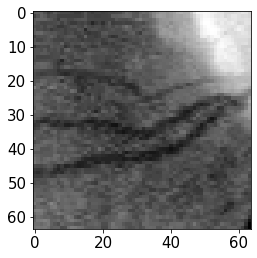

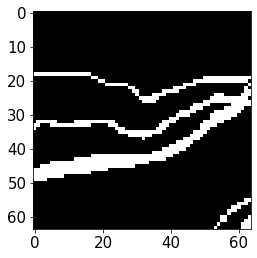

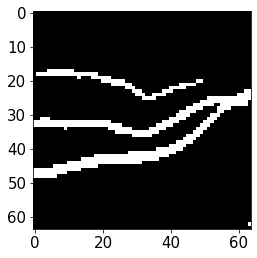

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(inputs.cpu().numpy()[9,0,:,:], cmap="gray")
plt.show()
plt.imshow(targets.cpu().numpy()[9,:,:], cmap="gray")
plt.show()
plt.imshow(prediction.cpu().numpy()[9,:,:], cmap="gray")
plt.show()

# Evaluation

In [ ]:
net.eval()
val_loss = AverageMeter()

with torch.no_grad():
  for batch_idx, (inputs, targets) in tqdm(enumerate(val_loader), total=len(val_loader)):
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    val_loss.update(loss.item(), inputs.size(0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/32 [00:00<?, ?it/s]


In [ ]:
inputs.shape, targets.shape, outputs.shape

(torch.Size([64, 1, 64, 64]),
 torch.Size([64, 64, 64]),
 torch.Size([64, 2, 64, 64]))

In [ ]:
prediction = outputs.argmax(dim = 1)

In [ ]:
inputs.shape, targets.shape, prediction.shape

(torch.Size([64, 1, 64, 64]),
 torch.Size([64, 64, 64]),
 torch.Size([64, 64, 64]))

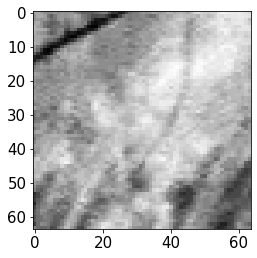

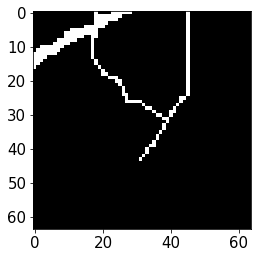

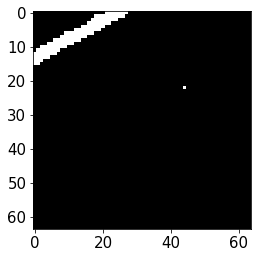

In [ ]:
plt.imshow(inputs.cpu().numpy()[9,0,:,:], cmap="gray")
plt.show()
plt.imshow(targets.cpu().numpy()[9,:,:], cmap="gray")
plt.show()
plt.imshow(prediction.cpu().numpy()[9,:,:], cmap="gray")
plt.show()

In [ ]:
def main():
    setpu_seed(2021)
    args = parse_args()
    save_path = join(args.outf, args.save)
    save_args(args,save_path)

    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
    cudnn.benchmark = True
    
    log = Logger(save_path)
    sys.stdout = Print_Logger(os.path.join(save_path,'train_log.txt'))
    print('The computing device used is: ','GPU' if device.type=='cuda' else 'CPU')
    
    # net = models.UNetFamily.U_Net(1,2).to(device)
    net = models.LadderNet(inplanes=1, num_classes=2, layers=3, filters=16).to(device)
    print("Total number of parameters: " + str(count_parameters(net)))

    log.save_graph(net,torch.randn((1,1,48,48)).to(device).to(device=device))  # Save the model structure to the tensorboard file
    # torch.nn.init.kaiming_normal(net, mode='fan_out')      # Modify default initialization method
    # net.apply(weight_init)

    # The training speed of this task is fast, so pre training is not recommended
    if args.pre_trained is not None:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        checkpoint = torch.load(args.outf + '%s/latest_model.pth' % args.pre_trained)
        net.load_state_dict(checkpoint['net'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        args.start_epoch = checkpoint['epoch']+1

    # criterion = LossMulti(jaccard_weight=0,class_weights=np.array([0.5,0.5]))
    criterion = CrossEntropyLoss2d() # Initialize loss function

    # create a list of learning rate with epochs
    # lr_epoch = np.array([50, args.N_epochs])
    # lr_value = np.array([0.001, 0.0001])
    # lr_schedule = make_lr_schedule(lr_epoch,lr_value)
    # lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)
    # optimizer = optim.SGD(net.parameters(),lr=lr_schedule[0], momentum=0.9, weight_decay=5e-4, nesterov=True)
    optimizer = optim.Adam(net.parameters(), lr=args.lr)
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.N_epochs, eta_min=0)
    
    train_loader, val_loader = get_dataloader(args) # create dataloader

    if args.val_on_test: 
        print('\033[0;32m===============Validation on Testset!!!===============\033[0m')
        val_tool = Test(args) 

    best = {'epoch':0,'AUC_roc':0.5} # Initialize the best epoch and performance(AUC of ROC)
    trigger = 0  # Early stop Counter
    for epoch in range(args.start_epoch,args.N_epochs+1):
        print('\nEPOCH: %d/%d --(learn_rate:%.6f) | Time: %s' % \
            (epoch, args.N_epochs,optimizer.state_dict()['param_groups'][0]['lr'], time.asctime()))
        
        # train stage
        train_log = train(train_loader,net,criterion, optimizer,device) 
        # val stage
        if not args.val_on_test:
            val_log = val(val_loader,net,criterion,device)
        else:
            val_tool.inference(net)
            val_log = val_tool.val()

        log.update(epoch,train_log,val_log) # Add log information
        lr_scheduler.step()

        # Save checkpoint of latest and best model.
        state = {'net': net.state_dict(),'optimizer':optimizer.state_dict(),'epoch': epoch}
        torch.save(state, join(save_path, 'latest_model.pth'))
        trigger += 1
        if val_log['val_auc_roc'] > best['AUC_roc']:
            print('\033[0;33mSaving best model!\033[0m')
            torch.save(state, join(save_path, 'best_model.pth'))
            best['epoch'] = epoch
            best['AUC_roc'] = val_log['val_auc_roc']
            trigger = 0
        print('Best performance at Epoch: {} | AUC_roc: {}'.format(best['epoch'],best['AUC_roc']))
        # early stopping
        if not args.early_stop is None:
            if trigger >= args.early_stop:
                print("=> early stopping")
                break
        torch.cuda.empty_cache()
if __name__ == '__main__':
    main()